In [1]:
import numpy as np
import pandas as pd
import scipy

import hdf5plugin
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec 
%matplotlib inline

import warnings

import pathlib

import os

import json

In [2]:
base_path = pathlib.Path('/mnt_blpc3/datax/scratch/andresl/pipeline-runs/all-bands/full-run-30k/')
assert base_path.is_dir()

In [3]:
with open(base_path / 'meta.json', 'r') as f:
    meta = json.load(f)
meta

{'start_time': '2025-08-03T06:49:29.172661+00:00',
 'outdir': 'full-run',
 'freq_window': 1024,
 'warm_significance': 4.0,
 'hot_significance': 8.0,
 'hotter_significance': 7.0,
 'sigma_clip': 3.0,
 'min_freq': 1100.0,
 'max_freq': 11200.0,
 'merge_info': {'merged_at': '2025-08-04T08:13:22.639199',
  'total_rows': 51784524,
  'output_format': 'csv',
  'compressed': False,
  'sorted_by': 'frequency',
  'merged_file': 'merged_data.csv'}}

In [4]:
tables = [base_path / 'batches' / table for table in sorted(os.listdir(base_path/'batches'))]
nums = [len(pd.read_csv(table)) for table in tables]
plt.bar(np.arange(len(nums)), nums)
plt.yscale('log');

FileNotFoundError: [Errno 2] No such file or directory: '/mnt_blpc3/datax/scratch/andresl/pipeline-runs/all-bands/full-run-30k/batches'

In [4]:
# TABLE_PATH = tables[32]
# TABLE_PATH = '/home/andres/breakthrough-listen/rfi-pipeline/test/batches/batch_000.csv'
TABLE_PATH = base_path / 'merged_data.csv'
print(TABLE_PATH)
df = pd.read_csv(TABLE_PATH)
df

/mnt_blpc3/datax/scratch/andresl/pipeline-runs/all-bands/full-run-30k/merged_data.csv


,frequency_index,frequency,kurtosis,snr,width,flags,source file,batch_number
0,9470976,1100.001117,4.000909,27.262258,1.1875,blip,/datag/pipeline/AGBT22A_999_08/blc46_blp06/blc...,29
1,9470976,1100.001376,10.504136,5.224132,1.8125,blip,/datag/pipeline/AGBT22B_999_12/blc36_blp06/blc...,11
2,9470976,1100.001630,6.697431,4.194527,1.3125,NaN,/datag/pipeline/AGBT23A_999_47/blc46_blp06/blc...,7
3,295731712,1100.002458,12.950954,10.806050,1.1875,NaN,/datag/pipeline/AGBT18A_999_36/holding/spliced...,24
4,295732224,1100.002459,16.759766,10.930319,1.1875,NaN,/datag/pipeline/AGBT18A_999_36/holding/spliced...,24
...,...,...,...,...,...,...,...,...
51784519,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT23B_999_01/blc43_blp03/blc...,29
51784520,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT20B_999_09/blc53_blp13/blc...,29
51784521,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT20A_999_47/blc63_blp23/blc...,29
51784522,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT19A_999_71/blc63/blc63_gup...,29


In [5]:
OUTDIR = pathlib.Path('./full-run-images').absolute()
OUTDIR

PosixPath('/mnt_home/andresl/rfi-pipeline/experiments/full-run-images')

In [6]:
# f = h5py.File(fname)
# fch1 = f['data'].attrs['fch1']
# foff = f['data'].attrs['foff']
# nchans = f['data'].attrs['nchans']
# tsamp = f['data'].attrs['tsamp']
# nfpc = f['data'].attrs.get('nfpc', 1<<20)
# WINDOW_SIZE = 2**10
# WINDOW_SIZE = 64
WINDOW_SIZE = meta['freq_window']

In [7]:
def threshold_based_width_estimation(spectrum):
    """
    Threshold-based width estimation (same as filejob.py)
    
    Find noise floor using sigma clipping, calculate middle point between noise and peak,
    then find width where signal drops below this threshold.
    """
    data = spectrum.copy()
    for _ in range(16): 
        mean_val = np.mean(data)
        std_val = np.std(data)
        lower_bound = mean_val - 2.0 * std_val
        upper_bound = mean_val + 2.0 * std_val
        
        mask = (data >= lower_bound) & (data <= upper_bound)
        if np.sum(mask) == 0: 
            break
        data = data[mask]

    noise_floor = np.median(data)
    
    # Find peak
    peak_value = np.max(spectrum)
    peak_idx = np.argmax(spectrum)
    
    # Calculate threshold (middle point between noise and peak)
    threshold = (noise_floor + peak_value) / 2
    
    # Find points above threshold around the peak
    above_threshold = spectrum > threshold
    
    if not np.any(above_threshold):
        return np.nan, np.nan, np.nan, np.nan
    
    # Find the contiguous region around the peak (brightest signal)
    # Start from the peak and expand left and right while above threshold
    left_idx = peak_idx
    right_idx = peak_idx
    
    # Expand left from peak
    while left_idx > 0 and above_threshold[left_idx - 1]:
        left_idx -= 1
    
    # Expand right from peak  
    while right_idx < len(spectrum) - 1 and above_threshold[right_idx + 1]:
        right_idx += 1
    
    # Calculate width of this contiguous region
    width = right_idx - left_idx + 1
    
    # Return parameters similar to what Gaussian fit would return
    # (mean, width, amplitude, noise_floor)
    amplitude = peak_value - noise_floor
    
    return float(peak_idx), float(width), float(amplitude), float(noise_floor)

def calculate_threshold_width(freq_array: np.ndarray, slice_data: np.ndarray, threshold_factor=3.0):
    """
    Calculate signal width using threshold method (wrapper for filejob method).
    Returns: (center_freq, width, amplitude, noise_level)
    """
    # Use the same method as filejob.py
    peak_idx, width_bins, amplitude, noise_level = threshold_based_width_estimation(slice_data)
    
    if np.isnan(peak_idx):
        return np.nan, np.nan, np.nan, np.nan
    
    # Convert peak index to frequency
    peak_freq = freq_array[int(peak_idx)]
    
    # Convert width from bins to frequency units
    width_freq = width_bins * abs(freq_array[1] - freq_array[0])
    
    return peak_freq, width_freq, amplitude, noise_level

def rectangular_model(x, center_freq, width, amplitude, noise_level):
    """
    Rectangular signal model for plotting (updated for filejob method)
    """
    result = np.full_like(x, noise_level)
    half_width = width / 2
    mask = np.abs(x - center_freq) <= half_width
    result[mask] = noise_level + amplitude
    return result

def calculate_frequency_widths(freq_array: np.ndarray, block: np.ndarray, threshold_factor=3.0):
    """
    Calculate width for each frequency slice of the block using filejob threshold method.
    Returns parameters for each slice: (center_freq, width, amplitude, noise_level)
    """
    all_params = []
    for i in range(block.shape[0]):
        slice_data = block[i, :]
        try:
            params = calculate_threshold_width(freq_array, slice_data, threshold_factor)
        except Exception as e:
            # Return NaN parameters for failed calculations
            params = (np.nan, np.nan, np.nan, np.nan)
        all_params.append(params)
    
    return np.array(all_params)

def zap_dc(block, l_idx):
    r_idx = l_idx + WINDOW_SIZE
    COARSE_PER_FINE = 2**20

    r_to_spike = (r_idx + COARSE_PER_FINE//2) % COARSE_PER_FINE

    spike_idx = WINDOW_SIZE - r_to_spike
    if (spike_idx < 0) or (spike_idx >= WINDOW_SIZE): return

    block[..., spike_idx] = (block[..., spike_idx-1] + block[..., spike_idx+1])/2

In [8]:
df

,frequency_index,frequency,kurtosis,snr,width,flags,source file,batch_number
0,9470976,1100.001117,4.000909,27.262258,1.1875,blip,/datag/pipeline/AGBT22A_999_08/blc46_blp06/blc...,29
1,9470976,1100.001376,10.504136,5.224132,1.8125,blip,/datag/pipeline/AGBT22B_999_12/blc36_blp06/blc...,11
2,9470976,1100.001630,6.697431,4.194527,1.3125,NaN,/datag/pipeline/AGBT23A_999_47/blc46_blp06/blc...,7
3,295731712,1100.002458,12.950954,10.806050,1.1875,NaN,/datag/pipeline/AGBT18A_999_36/holding/spliced...,24
4,295732224,1100.002459,16.759766,10.930319,1.1875,NaN,/datag/pipeline/AGBT18A_999_36/holding/spliced...,24
...,...,...,...,...,...,...,...,...
51784519,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT23B_999_01/blc43_blp03/blc...,29
51784520,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT20B_999_09/blc53_blp13/blc...,29
51784521,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT20A_999_47/blc63_blp23/blc...,29
51784522,-1,NaN,NaN,NaN,NaN,EMPTY FILE,/datag/pipeline/AGBT19A_999_71/blc63/blc63_gup...,29


hit['width'] = np.float64(1.0)


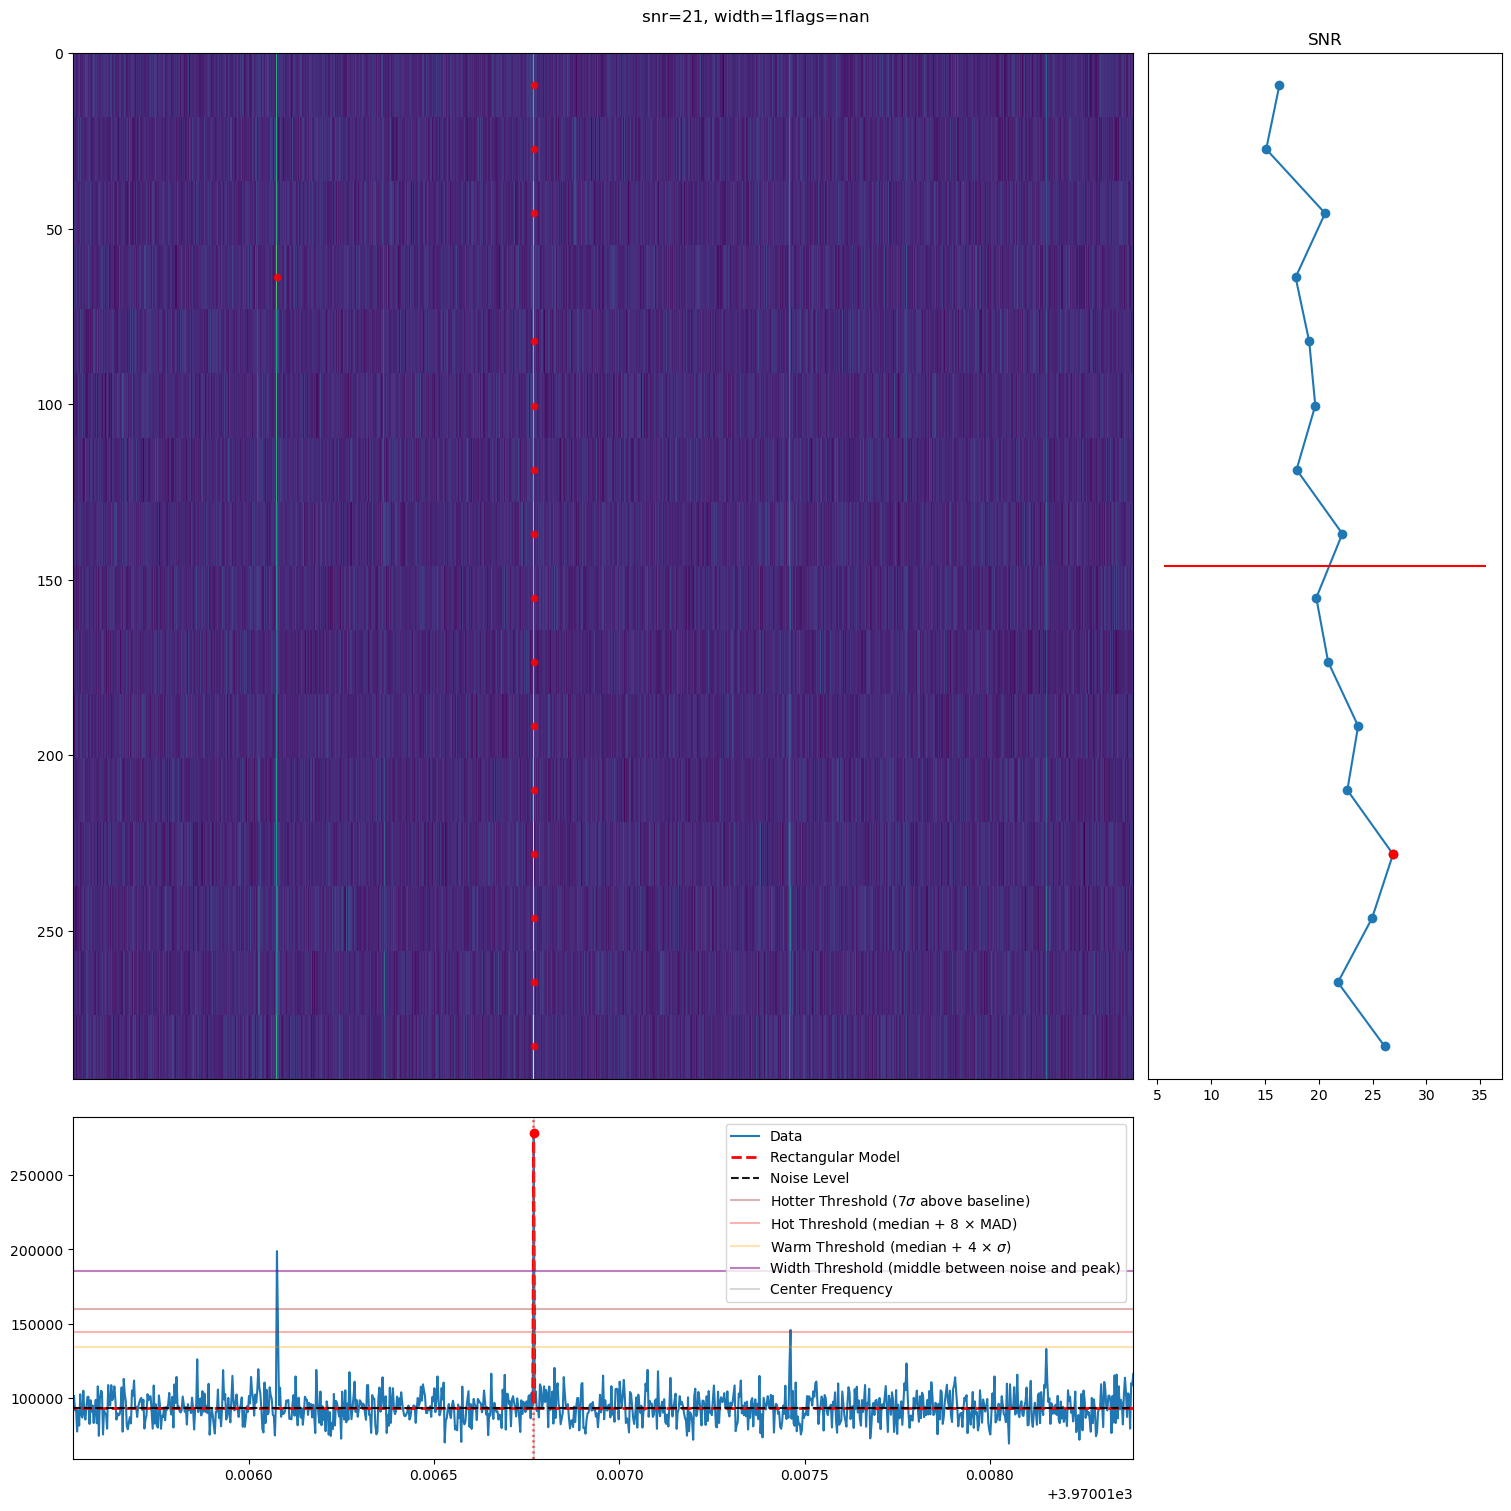

In [9]:
def make_figure(*, hit=None, filename=None, freq_index=None, title=None):
    if hit is not None:
        l_idx = hit.frequency_index
        if title is None:
            title = hit['flags'] if not pd.isna(hit['flags']) else '(no flags)'
        filename = hit['source file']
    elif (filename is not None) and (freq_index is not None):
        l_idx = freq_index
        if title is None:
            title = f'{filename}\n{freq_index = }'
    else:
        raise ValueError('Must provide one of (filename, freq_index) or hit')

    with h5py.File(filename, 'r') as f:
        data: np.ndarray = f['data'][:, 0, l_idx : l_idx+WINDOW_SIZE] # type: ignore
        fch1 = f['data'].attrs['fch1']
        foff = f['data'].attrs['foff']
        tsamp = f['data'].attrs['tsamp']

    zap_dc(data, l_idx)
    freqs = np.linspace(
        fch1 + l_idx*foff, 
        fch1 + (l_idx + data.shape[1])*foff,
        data.shape[1],
        endpoint=False
    )
    times = (np.arange(data.shape[0]) + 0.5) * tsamp
    
    # Use threshold-based width calculation instead of Gaussian fitting
    params = calculate_frequency_widths(freqs, data)

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 1], height_ratios=[3, 1])

    im_ax = fig.add_subplot(gs[0, 0])
    snr_ax = fig.add_subplot(gs[0, 1], sharey=im_ax)
    slice_ax = fig.add_subplot(gs[1, 0], sharex=im_ax)

    snr = []
    for time_idx in range(data.shape[0]):
        time_slice = data[time_idx]
        clipped, _, _ = scipy.stats.sigmaclip(time_slice, 3, 3)
        snr.append(
            (np.max(time_slice) - np.mean(clipped)) / np.std(clipped)
        )
    snr = np.array(snr)
    snr_ax.plot(snr, times, marker='o')
    snr_others = np.delete(snr, np.argmax(snr))
    snr_others_mad = np.std(snr_others)
    snr_ax.hlines(
        np.mean(times), 
        np.mean(snr_others) - 5*snr_others_mad, 
        np.mean(snr_others) + 5*snr_others_mad,
        color='red'
    )
    snr_ax.scatter(
        np.max(snr),
        times[np.argmax(snr)],
        color='red',
        zorder=10
    )
    if snr_ax.get_xlim()[0] < 0:
        snr_ax.axvline(1.0, color='gray')
    snr_ax.set_title('SNR')
    snr_ax.yaxis.set_visible(False) 

    im_ax.imshow(
        data,
        extent=(
            fch1 + foff*l_idx, fch1 + foff*(l_idx + data.shape[1]),
            data.shape[0] * tsamp, 0
        ),
        aspect='auto',
        interpolation='none'
    )
    
    # Plot center frequencies and widths instead of Gaussian parameters
    center_freqs = params[:, 0]
    widths = params[:, 1]
    
    # Plot center frequencies as points
    im_ax.scatter(center_freqs, times, color='red', s=20, alpha=0.8)
    
    # Plot width indicators as horizontal lines
    for i, (center_freq, width) in enumerate(zip(center_freqs, widths)):
        if not np.isnan(center_freq) and not np.isnan(width) and width > 0:
            half_width = width / 2
            im_ax.plot([center_freq - half_width, center_freq + half_width], 
                      [times[i], times[i]], color='red', alpha=0.6, linewidth=2)
    
    im_ax.invert_xaxis()
    im_ax.xaxis.set_visible(False)  # Hide x-axis on main plot

    # Choose middle time slice for detailed view
    SLICE_IDX = data.shape[0] // 2
    slice_data = data[SLICE_IDX, :]
    slice_ax.plot(freqs, slice_data, label='Data')
    
    # Plot rectangular model
    center_freq, width, amplitude, noise_level = params[SLICE_IDX]
    if not np.isnan(center_freq) and not np.isnan(width):
        model = rectangular_model(freqs, center_freq, width, amplitude, noise_level)
        slice_ax.plot(freqs, model, 'r--', linewidth=2, label='Rectangular Model')
        
        # Plot width boundaries
        half_width = width / 2
        slice_ax.axvline(center_freq - half_width, alpha=0.5, color='red', linestyle=':')
        slice_ax.axvline(center_freq + half_width, alpha=0.5, color='red', linestyle=':')

    slice_ax.axhline(noise_level, alpha = 0.9, color='black', linestyle='--', label='Noise Level')

    HOTTER_SIGNIFICANCE = 7
    clipped_slice, _, _ = scipy.stats.sigmaclip(slice_data)
    hotter_threshold = np.mean(clipped_slice) + HOTTER_SIGNIFICANCE * np.std(clipped_slice)
    slice_ax.axhline(hotter_threshold, alpha=0.3, color='darkred', label=f'Hotter Threshold ({HOTTER_SIGNIFICANCE}$\\sigma$ above baseline)')

    hot_threshold = noise_level + 8*scipy.stats.median_abs_deviation(slice_data)
    slice_ax.axhline(hot_threshold, alpha=0.3, color='red', label='Hot Threshold (median + 8 $\\times$ MAD)')

    others = np.delete(slice_data, np.argmax(slice_data))
    warm_threshold = noise_level + 4*np.std(others)
    slice_ax.axhline(warm_threshold, alpha=0.3, color='orange', label='Warm Threshold (median + 4 $\\times\\ \\sigma$)')

    # Threshold used for width calculation (filejob method: middle point between noise and peak)
    peak_value = np.max(slice_data)
    width_threshold = (noise_level + peak_value) / 2
    slice_ax.axhline(width_threshold, alpha=0.5, color='purple', label='Width Threshold (middle between noise and peak)')

    if not np.isnan(center_freq):
        slice_ax.axvline(center_freq, alpha=0.3, color='gray', label='Center Frequency')

    slice_ax.scatter(x=freqs[np.argmax(slice_data)], y=np.max(slice_data), color='red', zorder=10)

    slice_ax.legend()

    fig.suptitle(title)
    return fig

hit = df[df['source file'] == '/datag/pipeline/AGBT24B_999_01/blc65_blp35/blc65_guppi_60457_02547_DYSON1_0041.rawspec.0000.h5'].sample().iloc[0]
print(f'{hit['width'] = }')
# hit = df.loc[15]
make_figure(hit=hit, title=f'snr={hit['snr']:.3g}, width={hit['width']:.3g}flags={hit['flags']}')
# random_index = 1024 * np.random.randint(0, f['data'].shape[2]//1024)
# index = int((10562.495 - fch1) / foff) - 1024 * 2
# print('weird index:', index)
# make_figure(freq_index=index)
plt.show()

In [ ]:
hits_df = df[df['flags'] != 'EMPTY FILE']

In [ ]:
foff = h5py.File(df['source file'].iloc[0])['data'].attrs['foff']

In [ ]:
data = f['data'][:, 0, hit.frequency_index : hit.frequency_index+64].flatten()
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(data, bins='auto');
m = np.mean(data)
ax.hlines(10, m - np.std(data)*2, m + np.std(data)*2, color='red')
# ax.set_yscale('log')
plt.show()

In [ ]:
clipped = scipy.stats.sigmaclip(data, low=3, high=3).clipped

fig, ax = plt.subplots(figsize=(12,8))
ax.hist(clipped, bins='auto', rwidth=0.9);
m = np.mean(clipped)
ax.hlines(60, m - np.std(clipped)*2, m + np.std(clipped)*2, color='red', lw=5)
plt.show()

In [22]:
OUTDIR.mkdir(exist_ok=True)
for im in OUTDIR.glob('*'):
    os.remove(im)

In [ ]:
strip = 10 * np.log10(f['data'][8, 0, :])
for i in range(nfpc//2, len(strip), nfpc):
    strip[i] = (strip[i-1] + strip[i+1]) / 2

freqs = np.linspace(fch1, fch1 + foff*nchans, len(strip))

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle(f'Full Spectrum, DC spikes interpolated out\n{f.filename}\n{len(df):,} hits')

ax = fig.add_subplot()

ax.plot(freqs, strip, linewidth=0.5)
if meta.get('min_freq') is not None:
    ax.set_xlim(left=max(meta['min_freq'], fch1 + foff*nchans))
if meta.get('max_freq') is not None:
    ax.set_xlim(right=min(meta['max_freq'], fch1))

fig.savefig(OUTDIR/'spectrum.png', transparent=False)

In [ ]:
def save_hit_fig(hit, title=None, filename='image.png'):
    fig = make_figure(hit=hit, title=title)
    fig.savefig(filename, transparent=False)

    plt.close(fig)

In [25]:
df_normal = df[df['flags'].isna()]
NUM_NORMAL = 50
if len(df_normal) > NUM_NORMAL:
    df_normal = df_normal.sample(NUM_NORMAL) 
for i, (idx, normal_hit) in enumerate(df_normal.iterrows()):
    save_hit_fig(normal_hit, title=f'normal {idx}, freq={normal_hit['frequency']:.7f}, snr={normal_hit['snr']:.3g}', filename=str(OUTDIR/f'normal_{i:>02}.png'))

In [26]:
blip_df = df[df['flags'].str.contains('blip', na=False)]
if len(blip_df) > 25:
    blip_df = blip_df.sample(25)
for i, (idx, blip_hit) in enumerate(blip_df.iterrows()):
    save_hit_fig(blip_hit, title=f'blip {idx}, freq={blip_hit['frequency']:.7f}, snr={blip_hit['snr']:.3g},  {blip_hit['flags']}', filename=str(OUTDIR/f'blip_{i:>03}.png'))

In [27]:
bright_df = df[df['snr'] > 50]
if len(bright_df) >= 25:
    bright_df = bright_df.sample(25)
for i, (idx, bright_hit) in enumerate(bright_df.iterrows()):
    save_hit_fig(bright_hit, title=f'bright {idx}, freq={bright_hit['frequency']:.7f}, snr={bright_hit['snr']:.3g}, {bright_hit['flags']}', filename=str(OUTDIR/f'bright_{i:>03}.png'))

In [28]:
dim_df = df[df['snr'] < 9]
if len(dim_df) >= 25:
    dim_df = dim_df.sample(25)
for i, (idx, dim_hit) in enumerate(dim_df.iterrows()):
    save_hit_fig(dim_hit, title=f'dim {idx}, freq={dim_hit['frequency']:.7f}, snr={dim_hit['snr']:.3g}, {dim_hit['flags']}', filename=str(OUTDIR/f'dim_{i:>03}.png'))

In [29]:
wide_df = df[df['width'] > 3]
if len(wide_df) >= 25:
    wide_df = wide_df.sample(25)
for i, (idx, wide_hit) in enumerate(wide_df.iterrows()):
    save_hit_fig(wide_hit, title=f'wide {idx}, freq={wide_hit["frequency"]:.7f}, snr={wide_hit["snr"]:.3g}, width={wide_hit['width']:.3g}, {wide_hit["flags"]}', filename=str(OUTDIR/f'wide_{i:>03}.png'))

In [ ]:
plt.hist(np.log10(nums), bins='auto');